

# 5-Channel Bivariate vs. Multivariate MVAR Analysis
**SYNCCIN 2025 Summer School**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jzygierewicz/SYNCCIN_2025_summer_school/blob/main/5_channels_bivariate_multivariate_MVAR.ipynb)

---

## **Learning Objectives**

This notebook further explores the differences in bivariate and multivariate approaches to connectivity estimation using MVAR modeling and DTF analysis:

1. **Compare methodological approaches**: Understand when and why to use bivariate vs. multivariate methods
2. **Analyze spurious connections**: Learn how missing information leads to incorrect connectivity patterns
3. **Explore missing driver effects**: Investigate what happens when the true driving channel is excluded

## **Key Questions This Analysis Answers**

- **When do bivariate methods fail?** What are the limitations of pairwise analysis?
- **How does multivariate modeling improve accuracy?** Why consider all channels simultaneously?
- **What happens with missing drivers?** How do connectivity patterns change when key channels are excluded?
---

### Note: 

in this notebook we use fuctions from mtmvar.py to compute the spectra and DTF in bivariate and multivariate manner.

---

## **Setup: Install Dependencies & Download Data**
This cell installs all required packages and downloads the necessary data files from GitHub.

In [33]:
# Install required packages
!pip install joblib matplotlib numpy networkx plotly -q

print(" All packages installed successfully!")


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
 All packages installed successfully!


## **Download Required Files**
Download all necessary data files and Python modules from the GitHub repository.

In [32]:
import urllib.request
import os

# Base URL for the GitHub repository
base_url = "https://raw.githubusercontent.com/jzygierewicz/SYNCCIN_2025_summer_school/main/"

# Files to download
files_to_download = [
    "EEG_alpha.joblib",
    "mtmvar.py", 
    "utils.py"
]

print("Downloading files from GitHub repository...")

for file in files_to_download:
    if not os.path.exists(file):
        try:
            urllib.request.urlretrieve(base_url + file, file)
            print(f" Downloaded: {file}")
        except Exception as e:
            print(f" Error downloading {file}: {e}")
    else:
        print(f" Already exists: {file}")

print("\n All files ready for analysis!")

 Already exists: EEG_alpha.joblib
 Already exists: mtmvar.py
 Already exists: utils.py

 All files ready for analysis!


## **Import Libraries and Modules**
Import all necessary libraries including our custom MVAR analysis functions.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
import networkx as nx
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.subplots import make_subplots

# Local application/library imports
from mtmvar import (
    mvar_criterion, AR_coeff, mvar_H, 
    bivariate_spectra, multivariate_spectra, 
    DTF_bivariate, DTF_multivariate, 
    mvar_plot, graph_plot
)
from utils import describe_dict

print(" All libraries imported successfully!")

✅ All libraries imported successfully!


# **Data Preparation: Creating a 5-Channel Simulation**
We'll create a **controlled simulation** with 5 channels to compare bivariate vs. multivariate approaches:

- **Channel 0**: Original EEG signal (driving channel)
- **Channels 1-4**: Noisy delayed copies of Channel 0
- **Known connectivity**: Clear hierarchical structure with Channel 0 → Others

This setup allows us to:
1. **Evaluate method accuracy** against known ground truth
2. **Identify spurious connections** in bivariate analysis
3. **Test robustness** when the driver channel is missing
---

## **Load and Explore EEG Data**

In [7]:
# Load data from EEG_alpha.joblib
data = joblib.load('EEG_alpha.joblib')
print('data contents:')
describe_dict(data)

Fs = data['Fs'].item()
print(f"\n Sampling frequency: {Fs} Hz")
print(f" Available channels: {list(data['channels'].keys())}")
print(f" EEG data shape: {data['EEG'].shape}")

data contents:
EEG: ndarray, shape=(19, 7680), dtype=float64
Fs: ndarray, shape=(1, 1), dtype=uint8
channels: dict, keys=['O1', 'O2', 'T5', 'P3', 'Pz', 'P4', 'T6', 'T3', 'C3', 'Cz', 'C4', 'T4', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Fp1', 'Fp2']
ChanNames: list, length=19
N_chan: int, value=19

 Sampling frequency: 128 Hz
 Available channels: ['O1', 'O2', 'T5', 'P3', 'Pz', 'P4', 'T6', 'T3', 'C3', 'Cz', 'C4', 'T4', 'F7', 'F3', 'Fz', 'F4', 'F8', 'Fp1', 'Fp2']
 EEG data shape: (19, 7680)


## **Configure Simulation Parameters**

In [8]:
# Set the lag between the signals in samples
dt = 1  # 1 sample delay between consecutive channels

# Extract a fragment of the EEG data from channel O1
idx_t0 = 80
N = 2000
x1 = data['EEG'][data['channels']['O1'], idx_t0 : idx_t0 + N + 2*dt]
x1 = x1 / np.std(x1)  # normalize the signal
x1[20] = 30  # Add a marker to visualize delays between channels

## **Create Multi-Channel Simulation**
Create 5 channels with a **known connectivity structure**:
- **Channel 0**: Original signal (driver)
- **Channels 1-4**: Delayed, noisy copies
- **Progressive delays**: Each channel has increasing delay from the driver

In [9]:
# Create noisy copies of the signal
N = x1.shape[0]
A = 1  # Noise amplitude
x2 = x1 + A * np.random.randn(N)
x3 = x1 + A * np.random.randn(N)
x4 = x1 + A * np.random.randn(N)
x5 = x1 + A * np.random.randn(N)

# Form a multichannel array with progressive delays
# Each channel is delayed more than the previous one
sim1 = np.vstack((
    x1[4*dt:],           # Channel 0: least delay (driver)
    x2[3*dt:-1*dt],      # Channel 1: 1 sample delay
    x3[2*dt:-2*dt],      # Channel 2: 2 sample delay  
    x4[1*dt:-3*dt],      # Channel 3: 3 sample delay
    x5[:-4*dt]           # Channel 4: 4 sample delay
))

[N_chan, N_samp] = sim1.shape
sim_chan_names = ['0', '1', '2', '3', '4']  # Channel names

## **Visualize the Simulation Structure**
The simulation follows the scheme:

<img src="https://raw.githubusercontent.com/jzygierewicz/SYNCCIN_2025_summer_school/main/5chan_sim.png" alt="5-Channel Simulation Structure" width="50%"/>

Plot the first 50 samples to observe the **marker propagation** and **delay structure**.

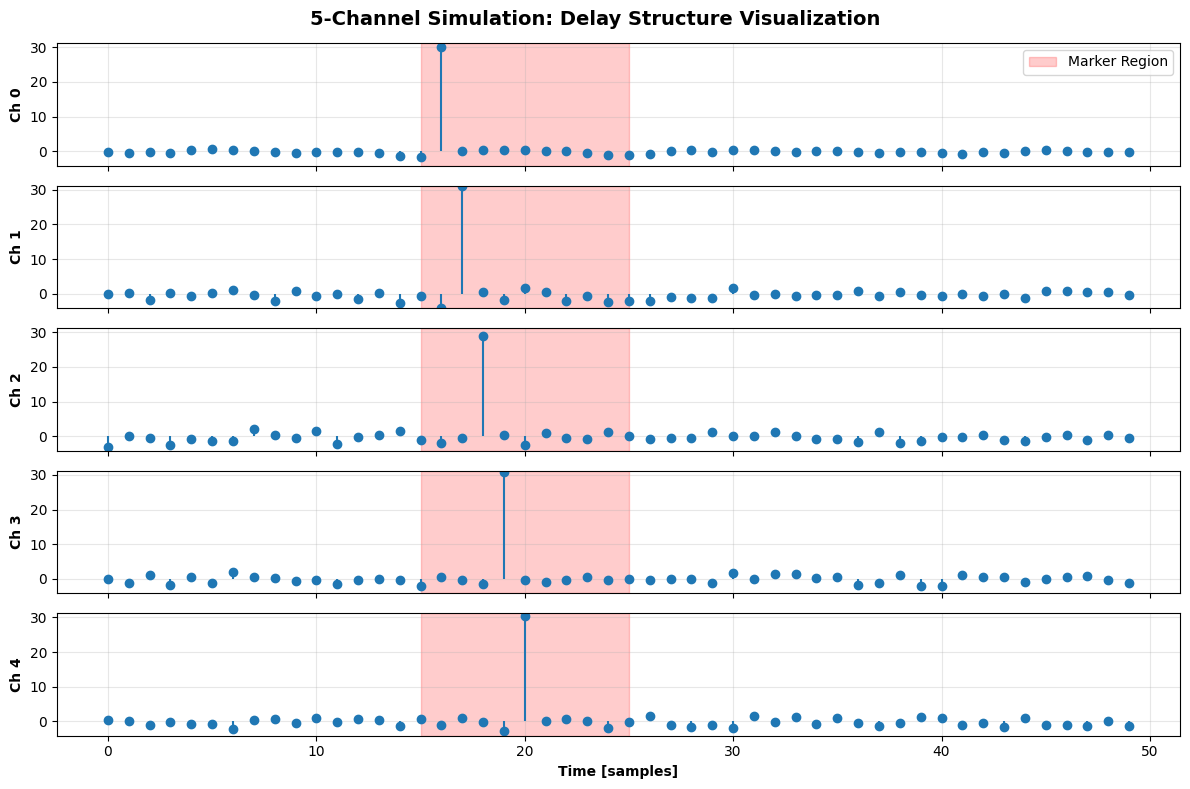

Observe the marker (red region) progression across channels
Notice how the marker appears later in higher-numbered channels
This demonstrates the simulated connectivity structure


In [10]:
# Visualize the first 50 samples to see the delay structure
idx = np.arange(0, 50, 1)
Min = np.min(sim1[:, idx])
Max = np.max(sim1[:, idx])

# Create figure with N_chan subplots
fig, ax = plt.subplots(N_chan, 1, sharex=True, figsize=(12, 8))
fig.suptitle('5-Channel Simulation: Delay Structure Visualization', fontsize=14, fontweight='bold')

for i in range(N_chan):
    ax[i].stem(idx, sim1[i, idx], basefmt=" ")
    ax[i].set_ylabel(f'Ch {i}', fontweight='bold')
    ax[i].set_ylim([Min, Max])
    ax[i].grid(True, alpha=0.3)
    
    # Highlight the marker region
    ax[i].axvspan(15, 25, alpha=0.2, color='red', label='Marker Region')

ax[N_chan-1].set_xlabel('Time [samples]', fontweight='bold')
ax[0].legend()
plt.tight_layout()
plt.show()

print("Observe the marker (red region) progression across channels")
print("Notice how the marker appears later in higher-numbered channels")
print("This demonstrates the simulated connectivity structure")

# **MVAR Model Estimation and Spectral Analysis**
## **Configure Analysis Parameters**

The optimal model order for MVAR can be selected using information criteria:

- **AIC (Akaike Information Criterion):**
    $$
    \mathrm{AIC}(p) = \ln\det(\mathbf{V}) + \frac{2 p k^2}{N}
    $$

- **HQ (Hannan-Quinn Criterion):**
    $$
    \mathrm{HQ}(p) = \ln\det(\mathbf{V}) + \frac{2 \ln\ln N \; p k^2}{N}
    $$

- **SC (Schwarz Criterion, BIC):**
    $$
    \mathrm{SC}(p) = \ln\det(\mathbf{V}) + \frac{\ln N \; p k^2}{N}
    $$

where:
- \( p \): model order
- \( k \): number of channels
- \( N \): number of samples
- \( \mathbf{V} \): residual covariance matrix

In [11]:
# Analysis parameters
max_p = 15  # Maximum model order to test
crit_type = 'AIC'  # Information criterion (AIC or HQ or SC for Akaike or Hannan-Quinn or Schwartz)
f = np.arange(0, 64, 0.1)  # Frequency vector for analysis
N_f = f.shape[0]

## **Bivariate Spectral Analysis**

Estimate **auto-spectra** and **cross-spectra** using the bivariate approach. Note how the optimal model order is estimated separately for each channel pair.

In [12]:
S_bivariate = bivariate_spectra(sim1, f, Fs, max_p, crit_type)

print("Bivariate spectral analysis completed!")
print("Note the different optimal orders printed above for each pair")

Optimal model order for channel pair:  0  and  1  p =  13
Optimal model order for channel pair:  0  and  2  p =  14
Optimal model order for channel pair:  0  and  3  p =  15
Optimal model order for channel pair:  0  and  4  p =  14
Optimal model order for channel pair:  1  and  2  p =  14
Optimal model order for channel pair:  1  and  3  p =  14
Optimal model order for channel pair:  1  and  4  p =  15
Optimal model order for channel pair:  2  and  3  p =  14
Optimal model order for channel pair:  2  and  4  p =  15
Optimal model order for channel pair:  3  and  4  p =  13
Bivariate spectral analysis completed!
Note the different optimal orders printed above for each pair


## **Multivariate Spectral Analysis**

Estimate spectra using the multivariate approach. Note how a **single optimal model order** is used for all channels simultaneously.

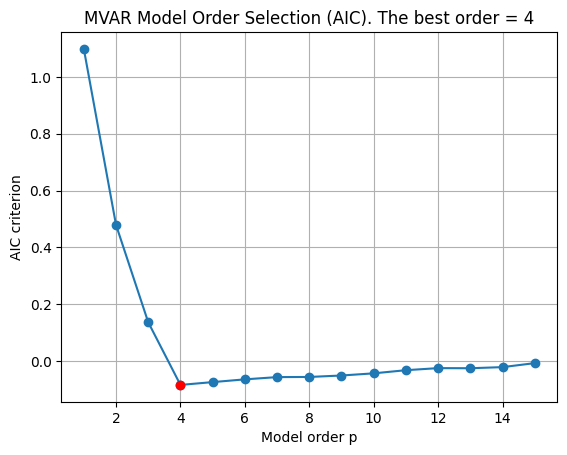

Optimal model order for all channels: p =  4
Multivariate spectral analysis completed!
Note the single optimal order for the entire system
Note also that it is lower than the maximum order used for bivariate analysis


In [14]:
S_multivariate = multivariate_spectra(sim1, f, Fs, max_p, crit_type)

print("Multivariate spectral analysis completed!")
print("Note the single optimal order for the entire system")
print("Note also that it is lower than the maximum order used for bivariate analysis")

## **Compare Spectral Estimates**

Visualize the **auto-spectra** (diagonal) and **cross-spectra** (off-diagonal) for both approaches.

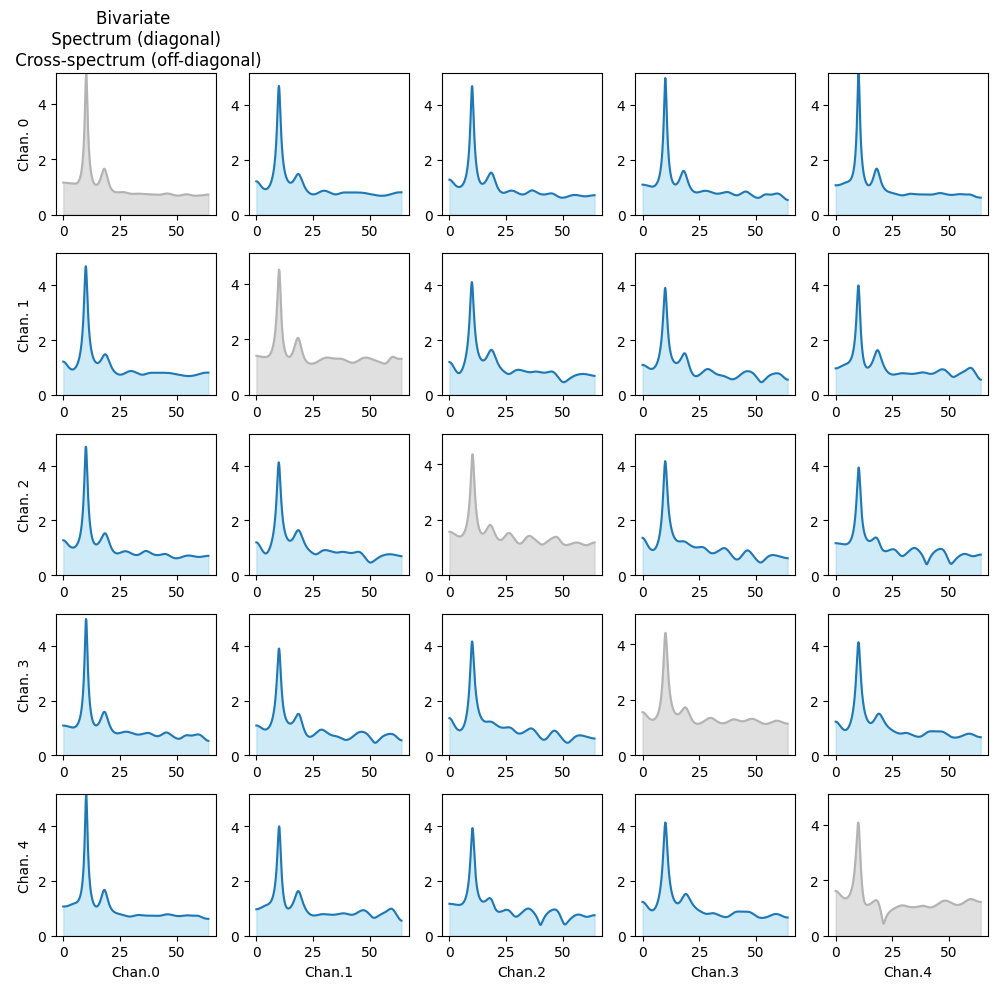

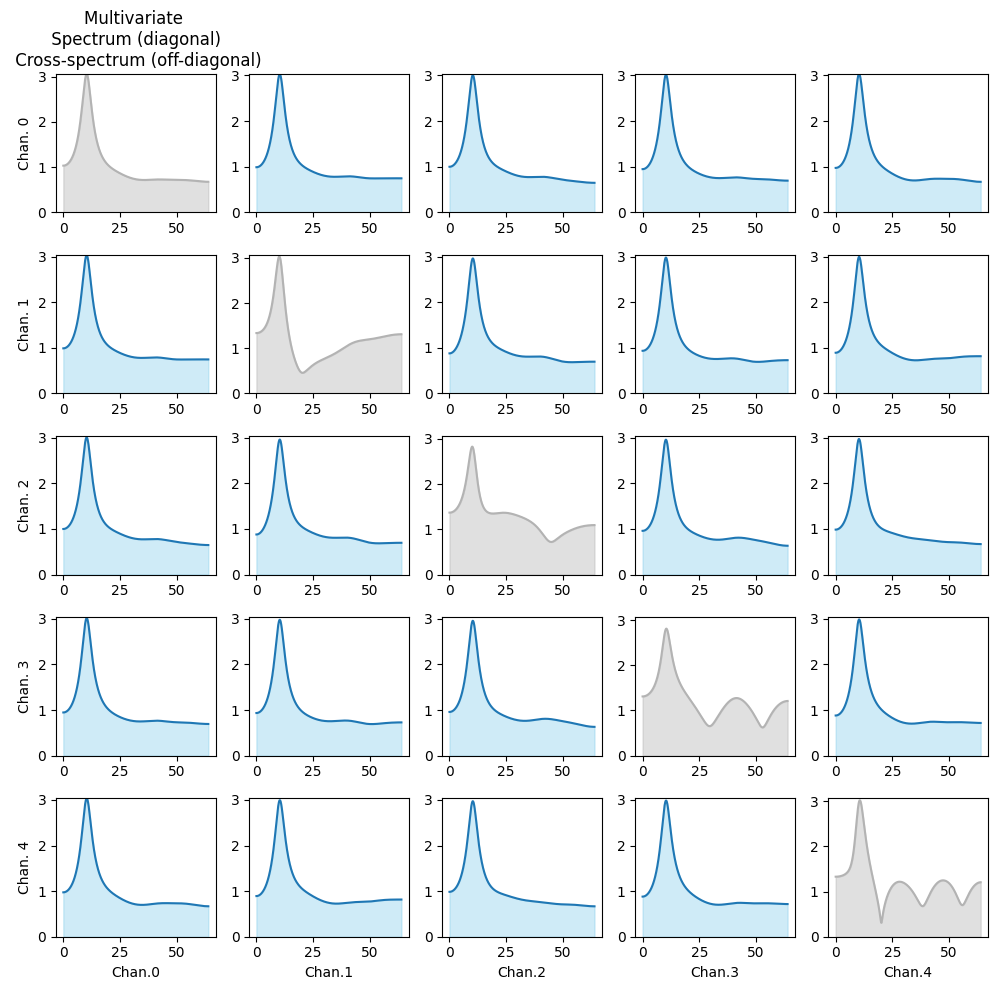


 Key Observations:
   Compare the cross-spectral patterns between methods
   Notice differences in spectral estimates
   Both should show strong alpha peak (~10 Hz)


In [17]:
# Plot bivariate spectra
mvar_plot(S_bivariate, S_bivariate, f, 'Chan.', 'Chan. ', sim_chan_names, 
          'Bivariate \n Spectrum (diagonal) \n Cross-spectrum (off-diagonal)', 'sqrt')
plt.show()

# Plot multivariate spectra  
mvar_plot(S_multivariate, S_multivariate, f, 'Chan.', 'Chan. ', sim_chan_names,
          'Multivariate \n Spectrum (diagonal) \n Cross-spectrum (off-diagonal)', 'sqrt')
plt.show()

print("\n Key Observations:")
print("   Compare the cross-spectral patterns between methods")
print("   Notice differences in spectral estimates")
print("   Both should show strong alpha peak (~10 Hz)")

# **Directed Transfer Function (DTF) Analysis**

## **Understanding DTF**

The **Directed Transfer Function (DTF)** quantifies the **directional connectivity** between channels:

- **DTF(i→j,f)**: Information flow from channel i to channel j at frequency f
- **Frequency-specific**: Reveals connectivity patterns in different frequency bands
- **Directional**: Shows the direction of information flow
---

## **Bivariate DTF Computation**

In [30]:
DTF_bi = DTF_bivariate(sim1, f, Fs, max_p=20, p_opt=None, crit_type='AIC')
print("Bivariate DTF computation completed!")

Bivariate DTF computation completed!


## **Multivariate DTF Computation**

In [31]:
DTF = DTF_multivariate(sim1, f, Fs, max_p=20, p_opt=None, crit_type='AIC')
print("Multivariate DTF computation completed!")

Multivariate DTF computation completed!


## **DTF Results: Matrix Visualization**

Compare DTF patterns between bivariate and multivariate approaches in **matrix form**.


 Analysis Points:
   Compare bidirectional vs unidirectional patterns


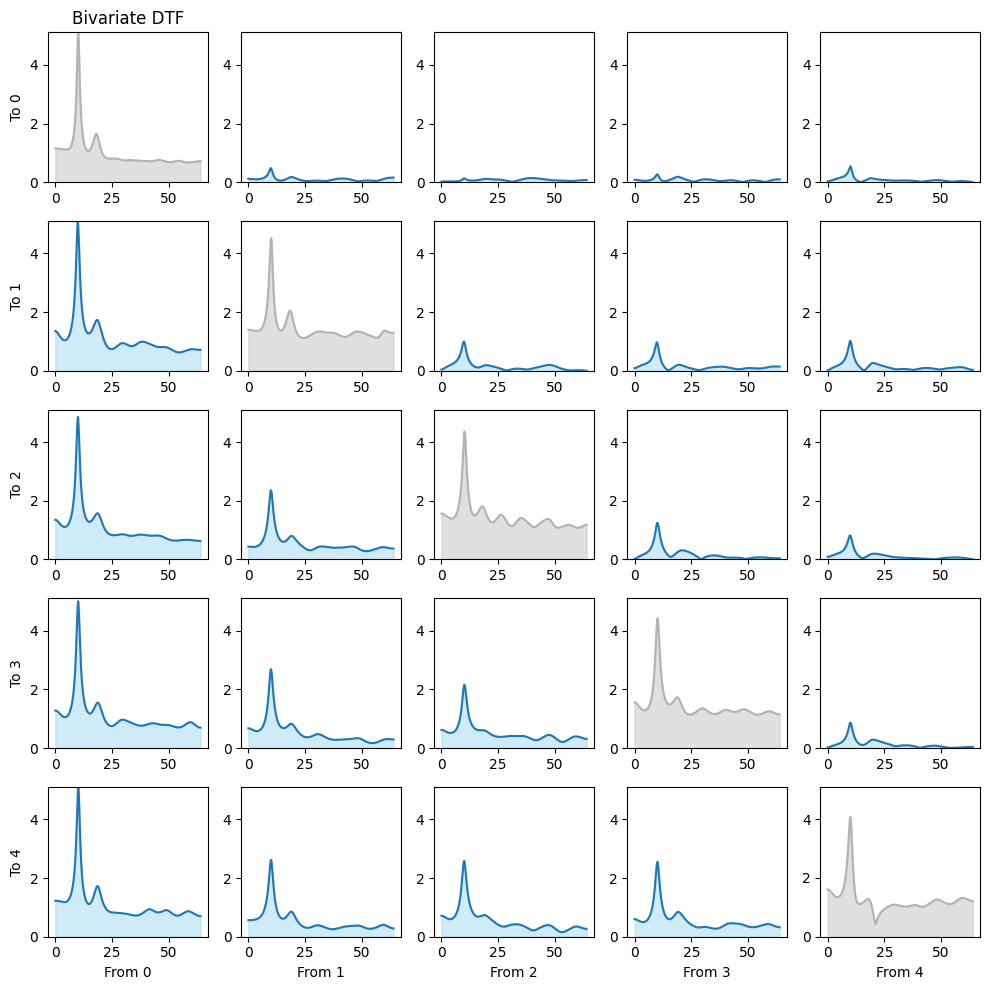

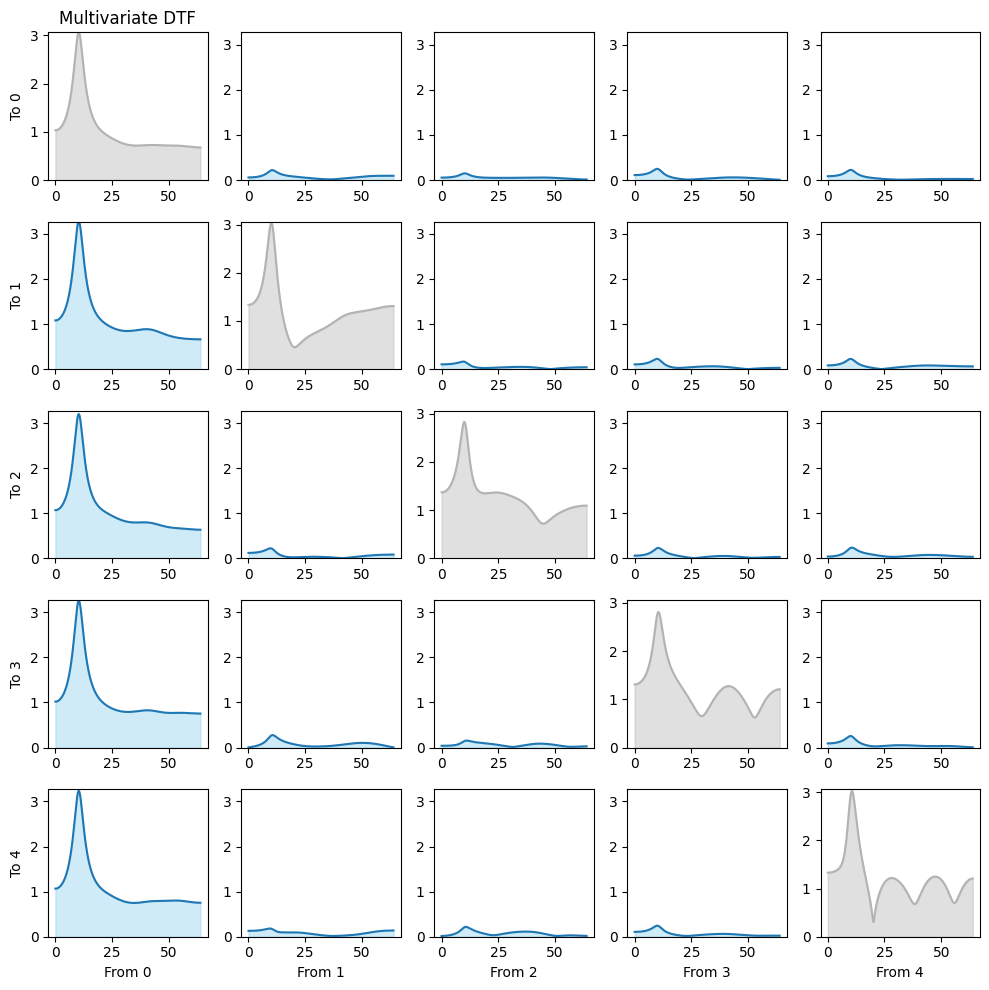

In [20]:
# Plot bivariate DTF
mvar_plot(S_bivariate, DTF_bi, f, 'From ', 'To ', sim_chan_names, 'Bivariate DTF', 'sqrt')

# Plot multivariate DTF
mvar_plot(S_multivariate, DTF, f, 'From ', 'To ', sim_chan_names, 'Multivariate DTF', 'sqrt')

print("\n Analysis Points:")
print("   Compare bidirectional vs unidirectional patterns")

## **Network Graph Visualization**
Visualize connectivity as **directed graphs** focused on the **alpha frequency band (8-12 Hz)**.

🕸 Creating network graphs for alpha band (8-12 Hz)...


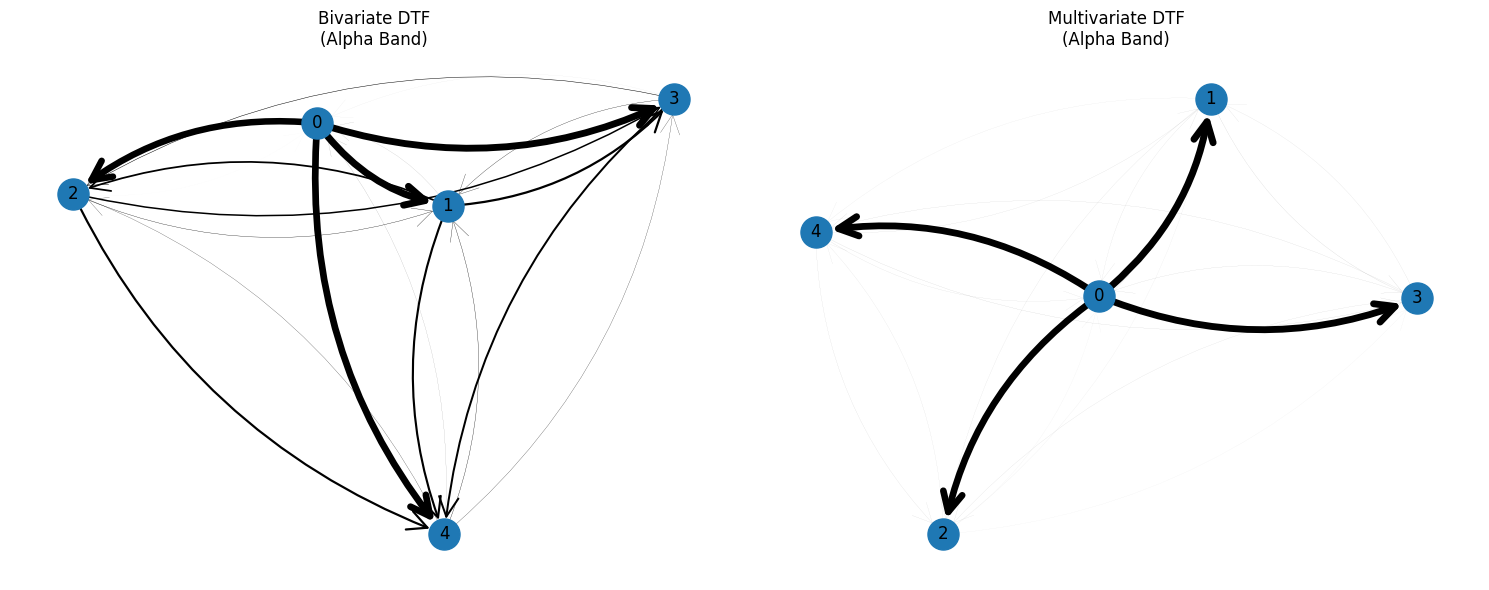


 Network Analysis:
   Left: Bivariate approach - Note spurious bidirectional connections
   Right: Multivariate approach - Cleaner unidirectional pattern
   Expected: Channel 0 as the main driver
   Bivariate shows many false connections due to indirect coupling


In [23]:
# Create side-by-side network graphs
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
f_range = (8, 12)  # Alpha frequency band

print(f"🕸 Creating network graphs for alpha band ({f_range[0]}-{f_range[1]} Hz)...")

# Bivariate network
G_bivariate = graph_plot(DTF_bi, axs[0], f, f_range, sim_chan_names, 'Bivariate DTF\n(Alpha Band)')

# Multivariate network  
G_multivariate = graph_plot(DTF, axs[1], f, f_range, sim_chan_names, 'Multivariate DTF\n(Alpha Band)')

plt.tight_layout()
plt.show()

print("\n Network Analysis:")
print("   Left: Bivariate approach - Note spurious bidirectional connections")
print("   Right: Multivariate approach - Cleaner unidirectional pattern")
print("   Expected: Channel 0 as the main driver")
print("   Bivariate shows many false connections due to indirect coupling")

# **Key Findings: Complete 5-Channel Analysis**
### **Bivariate Approach Limitations:**
- **Spurious connections**: Many false bidirectional links
- **Indirect coupling**: Cannot distinguish direct from indirect connections
- **Overestimation**: Shows more connections than actually exist

### **Multivariate Approach Advantages:**
- **Accurate detection**: Correctly identifies Channel 0 as driver
- **Direct connections**: Reveals true connectivity structure
- **System perspective**: Considers all channels simultaneously
- **Cleaner results**: Fewer spurious connections

---



# **Experiment 2: Missing Driver Channel Effect**

## **Research Question**

**What happens when the true driving channel is missing from the analysis?**

This is a **critical real-world scenario** in EEG analysis:
- **Limited electrode coverage**: Not all brain regions recorded
- **Artifact rejection**: Key channels may be excluded
- **Deep sources**: Subcortical drivers not directly observable

## **Simulate Missing Driver**

Replace Channel 0 (the true driver) with **random noise** to simulate a missing or corrupted channel.

In [24]:
sim1_missing = np.vstack((
    np.random.randn(N_samp),  # Noise channel replacing true driver
    x2[3*dt:-1*dt],           # Channel 1: still delayed copy of original
    x3[2*dt:-2*dt],           # Channel 2: still delayed copy of original  
    x4[1*dt:-3*dt],           # Channel 3: still delayed copy of original
    x5[:-4*dt]                # Channel 4: still delayed copy of original
))

[N_chan, N_samp] = sim1_missing.shape

print(f"Modified simulation: {N_chan} channels × {N_samp} samples")
print(f"Channel 0: Random noise (simulated missing driver)")
print(f"Channels 1-4: Still contain delayed copies of original signal")
print(f"Question: Which channel will appear as the new 'driver'?")

Modified simulation: 5 channels × 1998 samples
Channel 0: Random noise (simulated missing driver)
Channels 1-4: Still contain delayed copies of original signal
Question: Which channel will appear as the new 'driver'?


## **Recompute DTF with Missing Driver**

Analyze the same system but with the true driver channel replaced by noise.

Optimal model order for channel pair:  0  and  1  p =  14
Optimal model order for channel pair:  0  and  2  p =  14
Optimal model order for channel pair:  0  and  3  p =  14
Optimal model order for channel pair:  0  and  4  p =  13
Optimal model order for channel pair:  1  and  2  p =  14
Optimal model order for channel pair:  1  and  3  p =  14
Optimal model order for channel pair:  1  and  4  p =  15
Optimal model order for channel pair:  2  and  3  p =  14
Optimal model order for channel pair:  2  and  4  p =  15
Optimal model order for channel pair:  3  and  4  p =  13


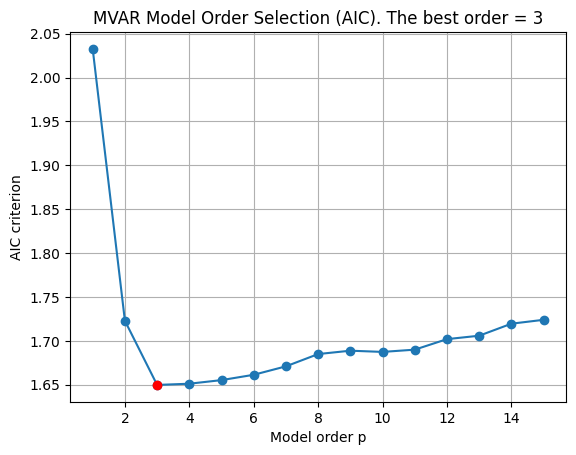

Optimal model order for all channels: p =  3
 Analysis with missing driver completed!
 Now let's see how the connectivity patterns changed...


In [25]:
# Bivariate analysis with missing driver
S_bivariate_missing = bivariate_spectra(sim1_missing, f, Fs, max_p, crit_type)
DTF_bi_missing = DTF_bivariate(sim1_missing, f, Fs, max_p=20, p_opt=None, crit_type='AIC')

# Multivariate analysis with missing driver
S_multivariate_missing = multivariate_spectra(sim1_missing, f, Fs, max_p, crit_type)
DTF_missing = DTF_multivariate(sim1_missing, f, Fs, max_p=20, p_opt=None, crit_type='AIC')

## **Missing Driver Results: Matrix View**

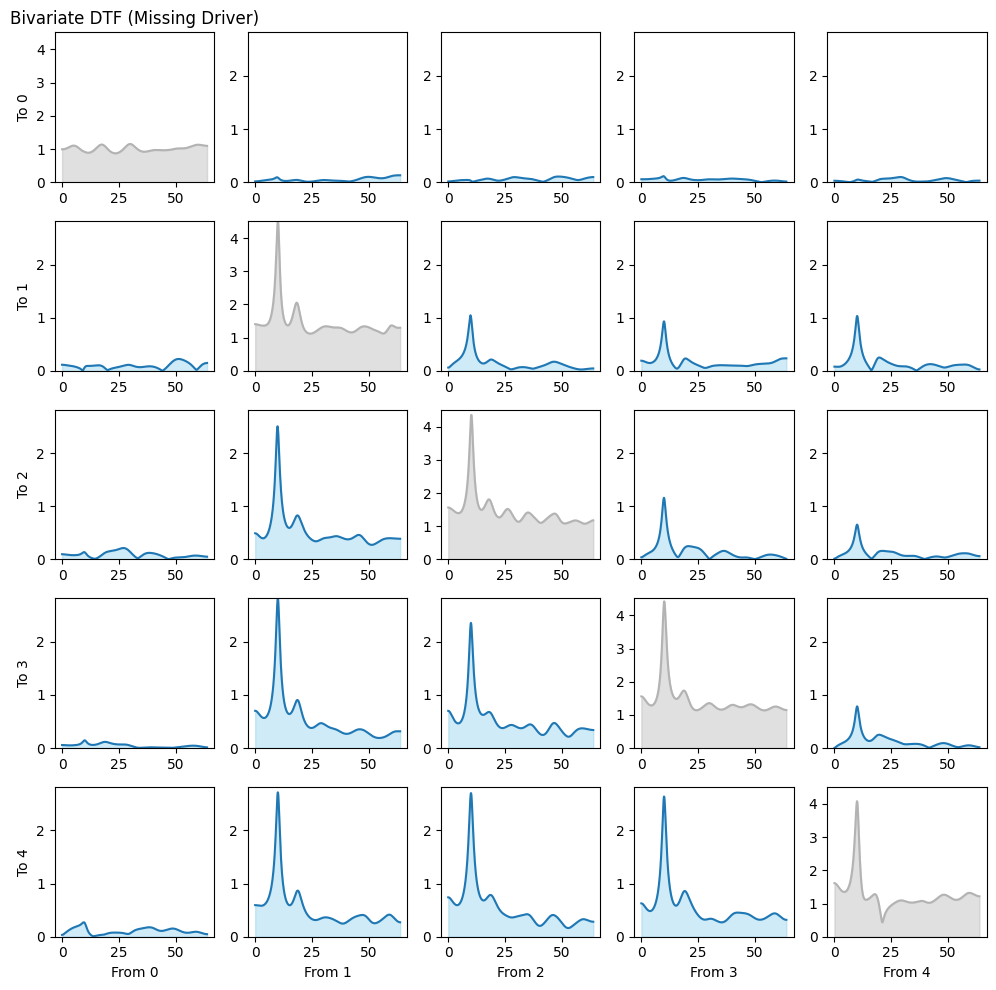

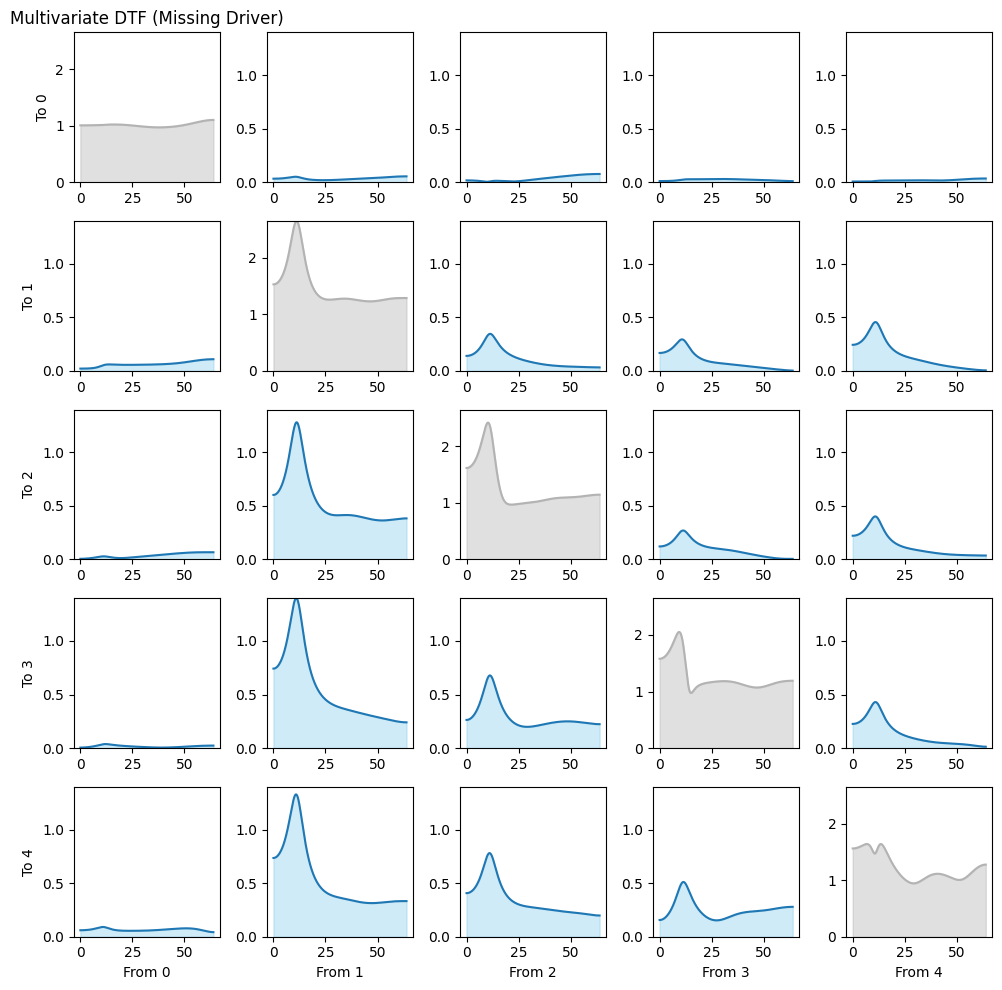


 Key Questions to Consider:
   Which channel now appears as the driver?
   How do the connectivity patterns differ?
   Can we detect that the true driver is missing?


In [27]:

mvar_plot(S_bivariate_missing, DTF_bi_missing, f, 'From ', 'To ', sim_chan_names, 
          'Bivariate DTF (Missing Driver)', 'sqrt')
mvar_plot(S_multivariate_missing, DTF_missing, f, 'From ', 'To ', sim_chan_names, 
          'Multivariate DTF (Missing Driver)', 'sqrt')
plt.show()

print("\n Key Questions to Consider:")
print("   Which channel now appears as the driver?")
print("   How do the connectivity patterns differ?")
print("   Can we detect that the true driver is missing?")

## **Missing Driver: Network Visualization**

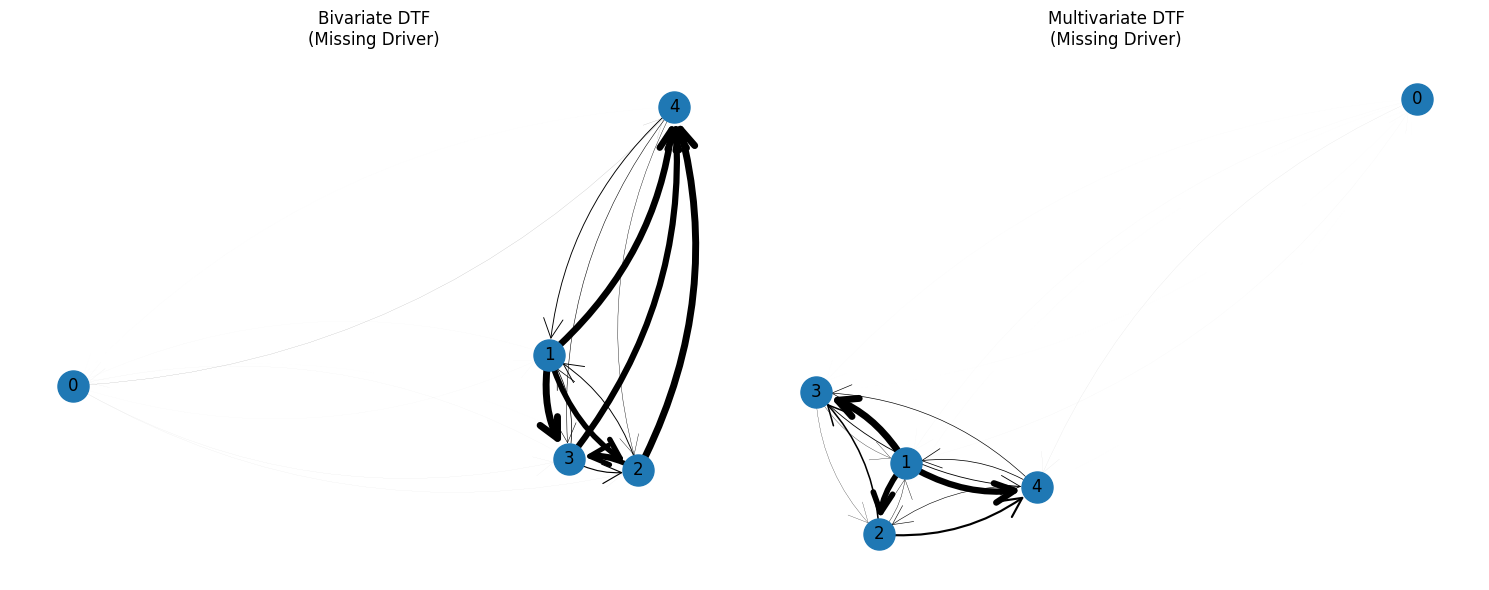

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
f_range = (8, 12)  # Alpha frequency band

G_bivariate_missing = graph_plot(DTF_bi_missing, axs[0], f, f_range, sim_chan_names, 
                                'Bivariate DTF\n(Missing Driver)')
G_multivariate_missing = graph_plot(DTF_missing, axs[1], f, f_range, sim_chan_names, 
                                   'Multivariate DTF\n(Missing Driver)')
plt.tight_layout()
plt.show()

### **Missing Driver Channel Effects**

#### **Critical Discovery:**
- **Driver substitution**: Channel with shortest delay becomes apparent driver
- **Method limitation**: Even multivariate analysis fails with missing drivers
- **Pattern distortion**: Connectivity structure changes dramatically
- **Clinical insight**: Emphasizes importance of careful consideration of recording channels
---


#### **Mitigation Strategies:**
- **Dense arrays**: Use high-density EEG when possible
- **Multiple analyses**: Test different channel combinations
- **Consistency checks**: Compare results across methods
- **Prior knowledge**: Incorporate anatomical/physiological constraints

---

**Educational Materials**: [SYNCCIN 2025 Repository](https://github.com/jzygierewicz/SYNCCIN_2025_summer_school)
- **Author**: Jarosław Żygierewicz
- **Institution**: University of Warsaw
- **Event**: SYNCCIN 2025 Summer School
